# UNet in PyTorch

## By Farzam

### PETS dataset


## Package Import

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

## Hyperparameters Setting

In [2]:
batch_size = 8

n_iters = 10000
epochs = 10

learning_rate = 0.00002
n_workers = 8

# Set Image and Mask shape.
width = 256
height = 256
channels = 3

# Setting device to Cuda if GPU is detected.
# Otherwise, it will use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting a specific seed to test the performance with Tensorflow and Jax
seed = 44

random.seed(seed)

torch.manual_seed(seed)

## Dataset Creation

We need to define a class to declare our dataset with it.
The dataset needs to have the paths to the images and masks dataset.
We also implement the dataset in a way that iteration through indices will return the objects using the `__get_item__` method.

In [3]:
class MyDataset(Dataset):
    # This class inherits from the `Dataset` class of Torch.
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        
        # Boolean: training mode 0 / 1
        self.train = train
        # If transformations are applied, we set them to the class attributes.
        self.transforms = transforms
        
        # Setting the path to the images.
        file_path = root_dir + 'images/*.*'
        
        # Setting the path to the masks.
        file_mask_path = root_dir + 'annotations/trimaps/*.*'
        
        # We need to sort the filenames we retrieved to match the images and masks correctly.
        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))
        
        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]
        
    # Using this method we can have access to the objects using indices from the dataset.
    def __getitem__(self, index: int):
        # Reading images using PIL. Converting them to the `RGB` mode.
        image = Image.open(self.images[index]).convert('RGB')
        
        # Reading soft-masks from the directory.
        image_mask = Image.open(self.image_mask[index]).convert('L')
        
        # If we manage to have transformations, here they will be applied to images and masks.
        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)
            # NOTE: According to the masks, we have set a treshold to make masks binary!
            # In this case pixel values below threshold will be set to 0.
            binary_mask = torch.where((image_mask <= 0.007), torch.tensor(1.), torch.tensor(0.))

        return {'img': image, 'mask': binary_mask}
    
    def __len__(self):
        return len(self.images)
    
# Applying transformations (resize and converting to Tensors)
transforms = T.Compose([
    T.Resize((width, height)),
    T.ToTensor(),
])

# Creating dataset object for train images.
train_dataset = MyDataset(root_dir='./../data/',
                                 train=True,
                                 transforms=transforms)

# Creating the dataset for validation data.
val_dataset = MyDataset(root_dir='./../data/',
                                train=False,
                                transforms=transforms)

# Creating the Torch dataloader based on our dataset.
# For training dataloader, we apply shuffle method to shuffle our data.
train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=n_workers)


val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=n_workers)

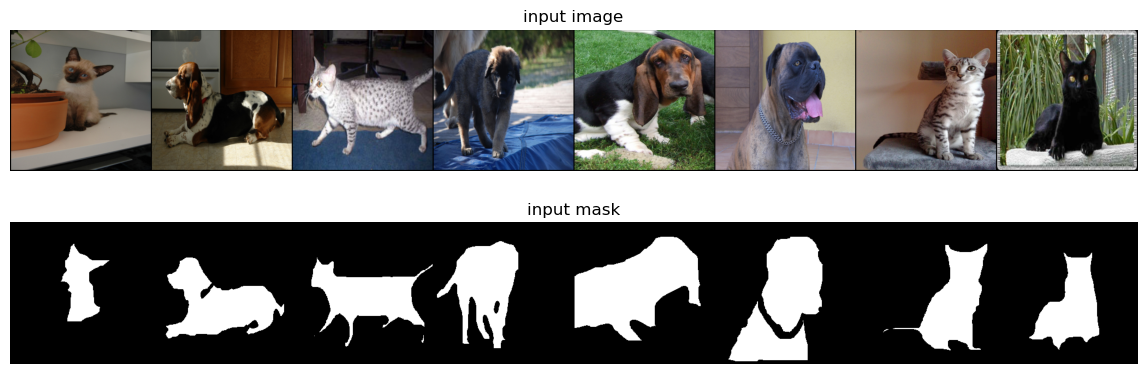

In [4]:
# Fetching a sample from the dataset to visualize the masks and images.
samples = next(iter(train_dataset_loader))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()


ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(), (1, 2, 0)))

ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(), (1, 2, 0)), cmap='gray')

plt.show()

In [5]:
# To implement the UNet module, we need convolutional blocks for up/downsampling.
# These convolutional blocks help us to have specific number of nodes for every single needed layer.
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            
            # NOTE: Testing BatchNormalization for next versions!
            # Not realiable at the moment.
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)

# To implement the bottle neck, we implement the SkipConnection class.
class SkipConnection(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = T.CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output


# Constructing the UNet architecture using the above implemented classes.
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()
        
        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.skipconnection = SkipConnection()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])
        
        # PixelShuffle, UpSample will modify the output channel (you can add extra operation to update the channel, e.g.conv2d)
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        
        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encod
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.skipconnection(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output

![](https://miro.medium.com/v2/resize:fit:1400/1*tSqwQ9tvLmeO9raDqg3i-w.png)

In [6]:
def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return np.mean(dice.cpu().numpy())

In [7]:
def pixel_accuracy(pred: torch.Tensor, mask: torch.Tensor):
    correct = torch.eq(pred, val_mask).int()
    return float(correct.sum()) / float(correct.numel())

In [8]:
def plot_pred_img(samples, pred):
    """
    For each iteration, it displays the sample unput, the truth mask, and the prediction of it.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                           (1, 2, 0)), cmap='gray')
    
    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                           (1, 2, 0)), cmap='gray')

    plt.show()
    
    
def plot_train_progress(model):
    samples = next(iter(val_dataset_loader))
    val_img = samples['img'].to(device)
    val_mask = samples['mask'].to(device)

    pred = model(val_img)
    
    plot_pred_img(samples, pred.detach())

In [9]:
def train(model, optimizer, criteration, scheduler=None):
    train_losses = []
    val_lossess = []
    lr_rates = []
    
    # calculate train epochs
    epochs = int(n_iters / (len(train_dataset) / batch_size))


    for epoch in range(epochs):
        model.train()        
        train_total_loss = 0
        train_iterations = 0
        
        # Iterate over the training dataloader to get the images and mask
        for idx, data in enumerate(tqdm(train_dataset_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)
            
            optimizer.zero_grad()
            
            # speed up the training
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()
            
            # training a machine learning model by backpropagating the loss and updating the model's parameters to improve its performance.
            train_loss.backward()
            optimizer.step()


        # Computing the epoch train loss and adding it to the losses list in `history`
        train_epoch_loss = train_total_loss / train_iterations
        train_losses.append(train_epoch_loss)
        
        # evaluate mode
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            scores = 0
            
            # Iterating over the validation dataset to acquire images and masks. 
            for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)

                with torch.autocast(device_type='cuda'):
                    pred = model(val_img)
                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    scores += dice_score(pred, val_mask)


            val_epoch_loss = val_total_loss / val_iterations
            dice_coef_scroe = scores / val_iterations

            val_lossess.append(val_epoch_loss)           

            plot_train_progress(model)
            
            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}'.format(
                epoch+1, epochs,
                idx+1, len(train_dataset_loader),
                dice_coef_scroe, train_epoch_loss, val_epoch_loss
            )) 
            
        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            # Decay learning rate
            scheduler.step() 
            print('LR rate:', scheduler.get_last_lr())
            
    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_lossess
    }

100%|██████████| 278/278 [00:06<00:00, 42.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


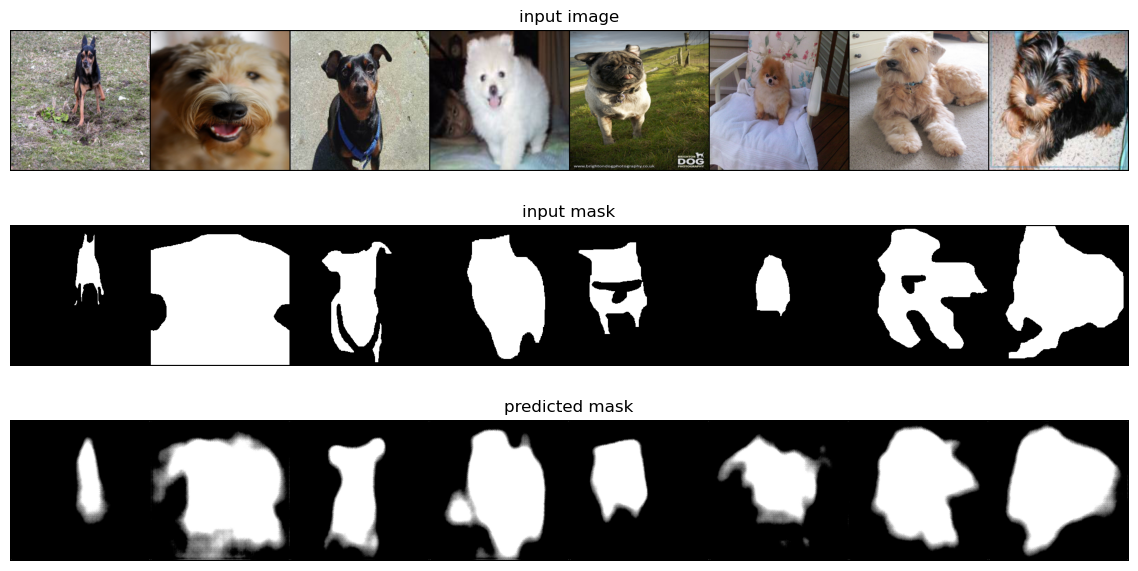

epochs - 1/15 [647/647], dice score: -24.557857308027554, train loss: 0.4708943874611184, val loss: 0.39498861927351503


100%|██████████| 278/278 [00:04<00:00, 60.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


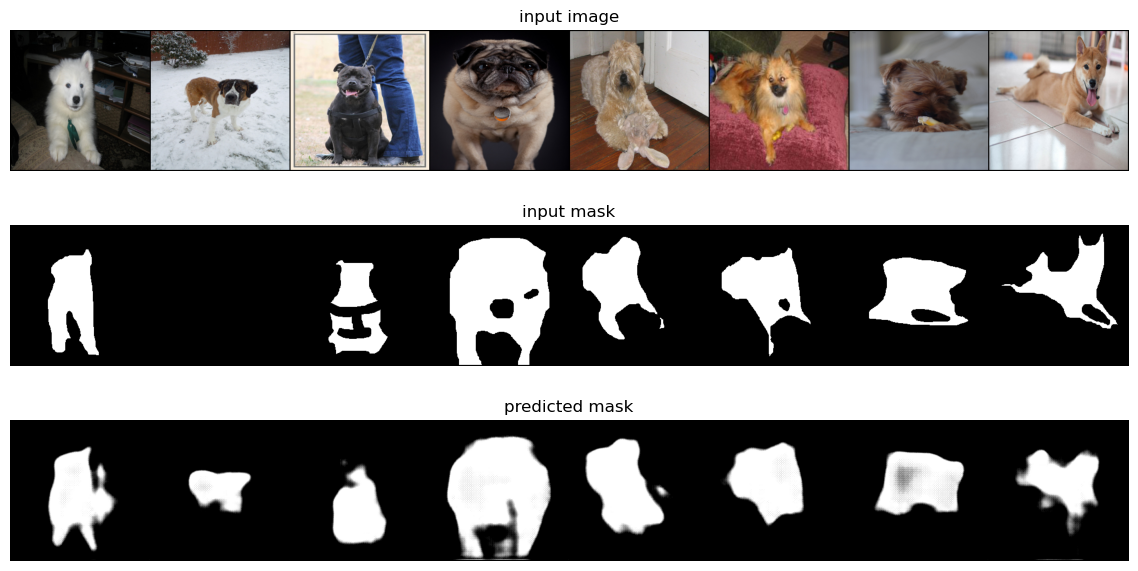

epochs - 2/15 [647/647], dice score: -2.1484001839010833, train loss: 0.38486526171796287, val loss: 0.372348181849761


100%|██████████| 278/278 [00:04<00:00, 61.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


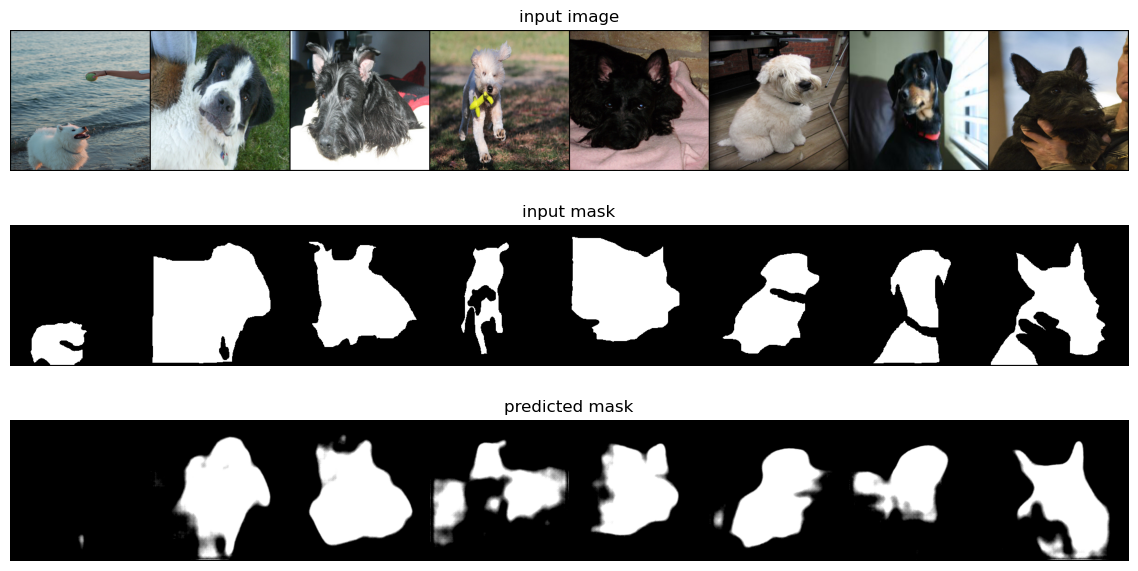

epochs - 3/15 [647/647], dice score: -1.7367561254784358, train loss: 0.3407832412207514, val loss: 0.3144539835320102


100%|██████████| 278/278 [00:04<00:00, 59.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


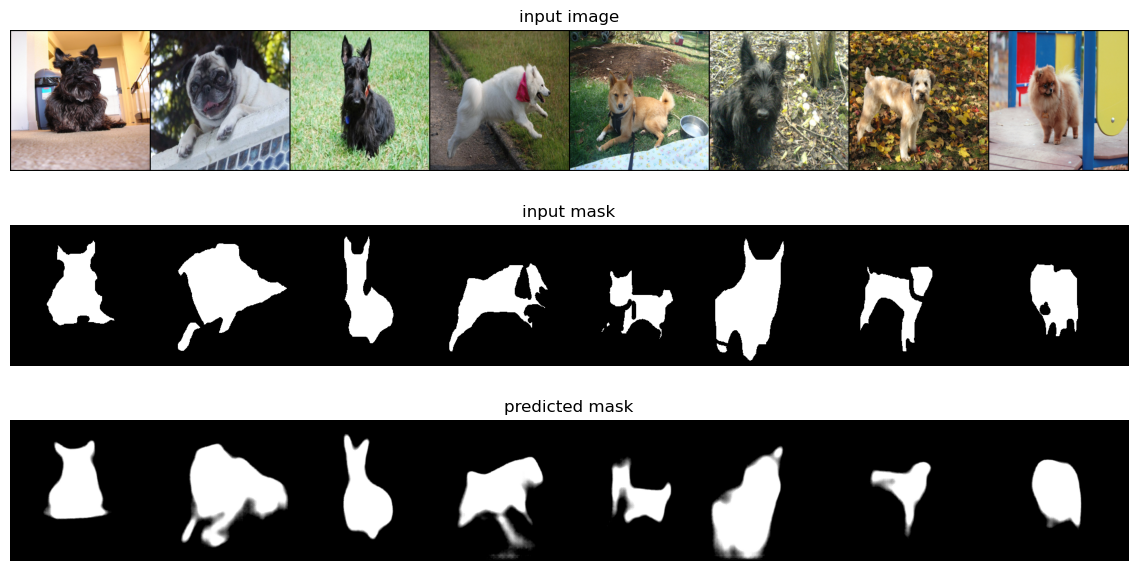

epochs - 4/15 [647/647], dice score: -2.6163514619894164, train loss: 0.30523444822711593, val loss: 0.2960647589011158


100%|██████████| 278/278 [00:04<00:00, 59.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


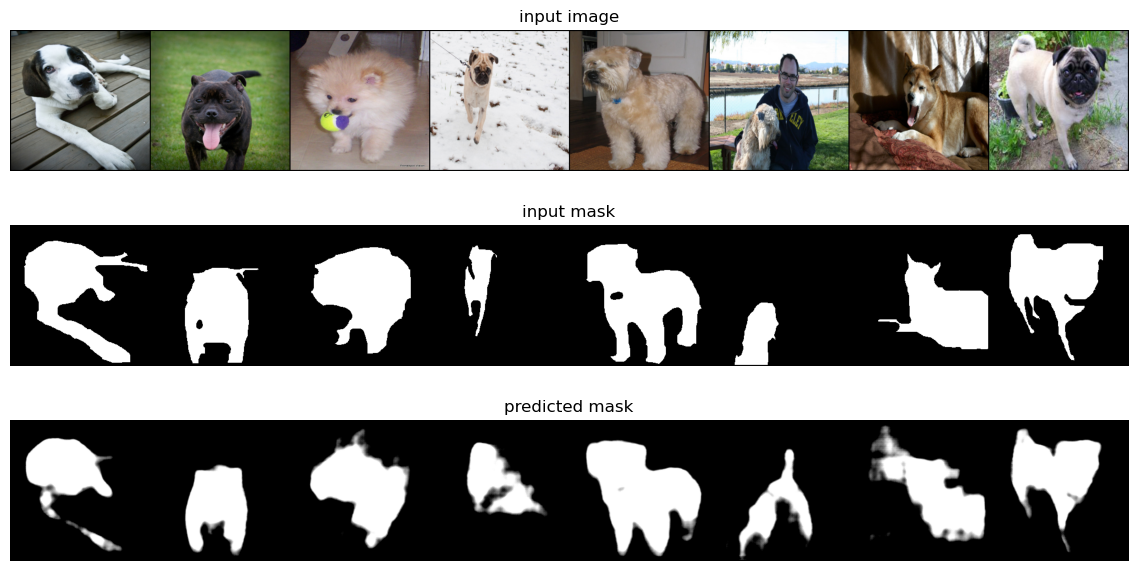

epochs - 5/15 [647/647], dice score: -1.5966245139305808, train loss: 0.28073621627628526, val loss: 0.25091675159742505


100%|██████████| 278/278 [00:04<00:00, 59.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


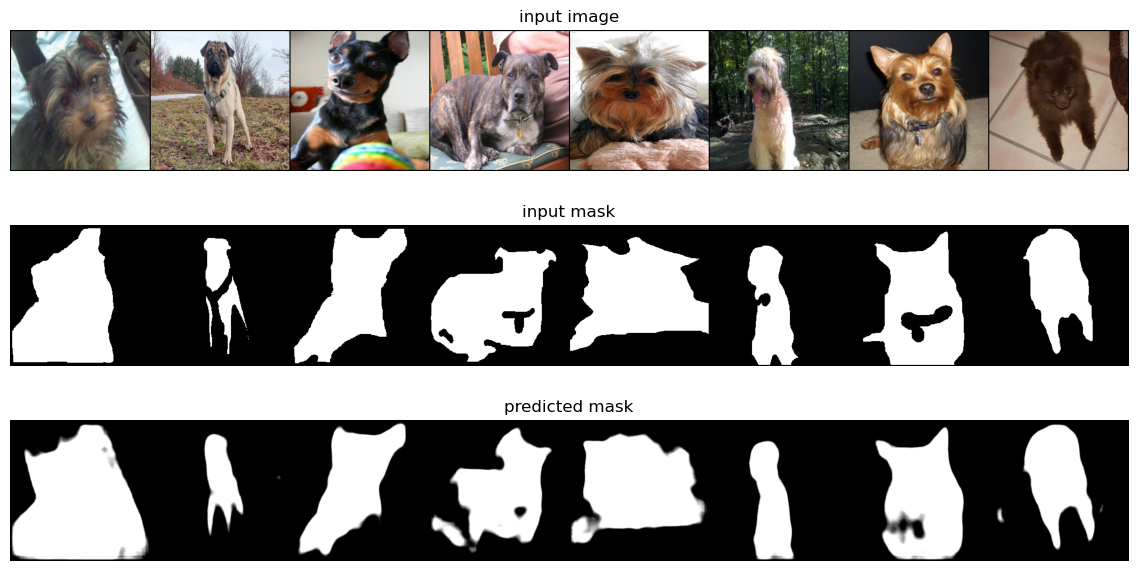

epochs - 6/15 [647/647], dice score: -0.022069580745782785, train loss: 0.26159997130103607, val loss: 0.23132266779597715


100%|██████████| 278/278 [00:04<00:00, 60.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


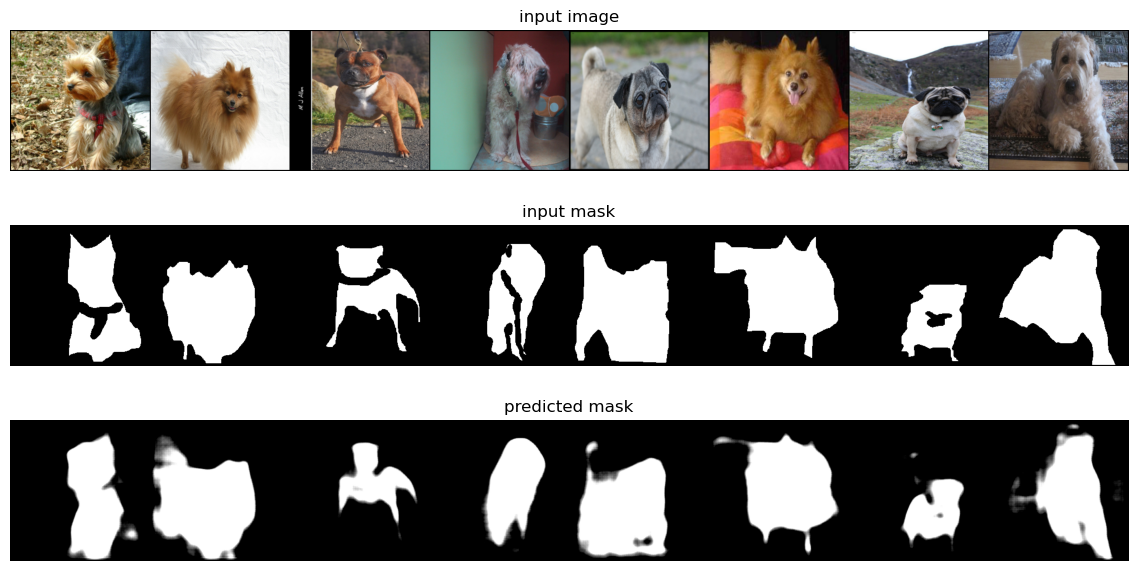

epochs - 7/15 [647/647], dice score: -1.0519109439077994, train loss: 0.24167759419408796, val loss: 0.2458881781898814


100%|██████████| 278/278 [00:04<00:00, 60.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


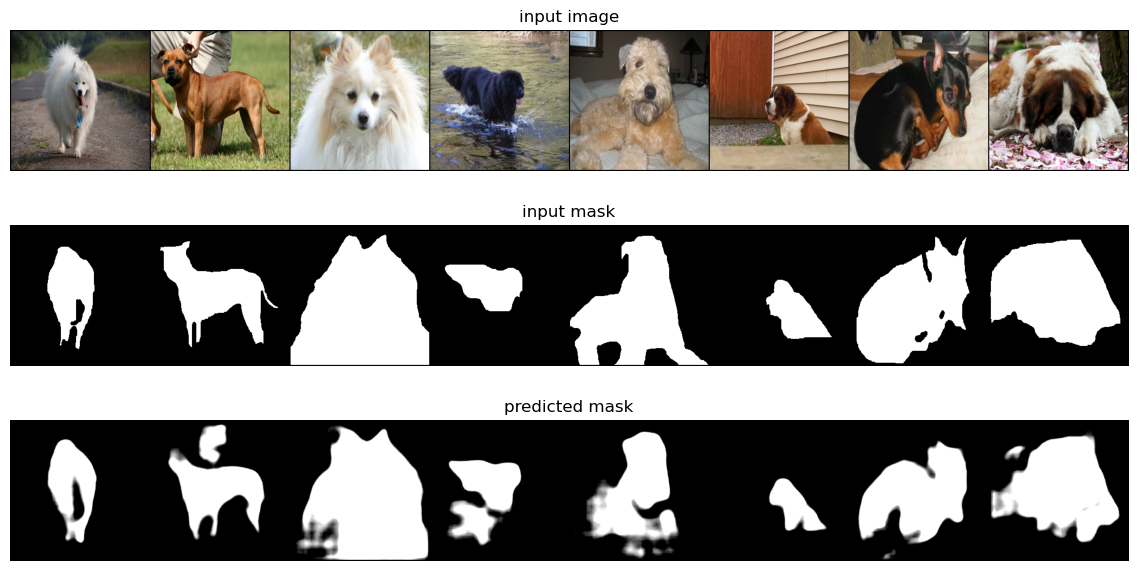

epochs - 8/15 [647/647], dice score: -0.30466966738374973, train loss: 0.2225712749882496, val loss: 0.23397486222733696


100%|██████████| 278/278 [00:04<00:00, 59.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


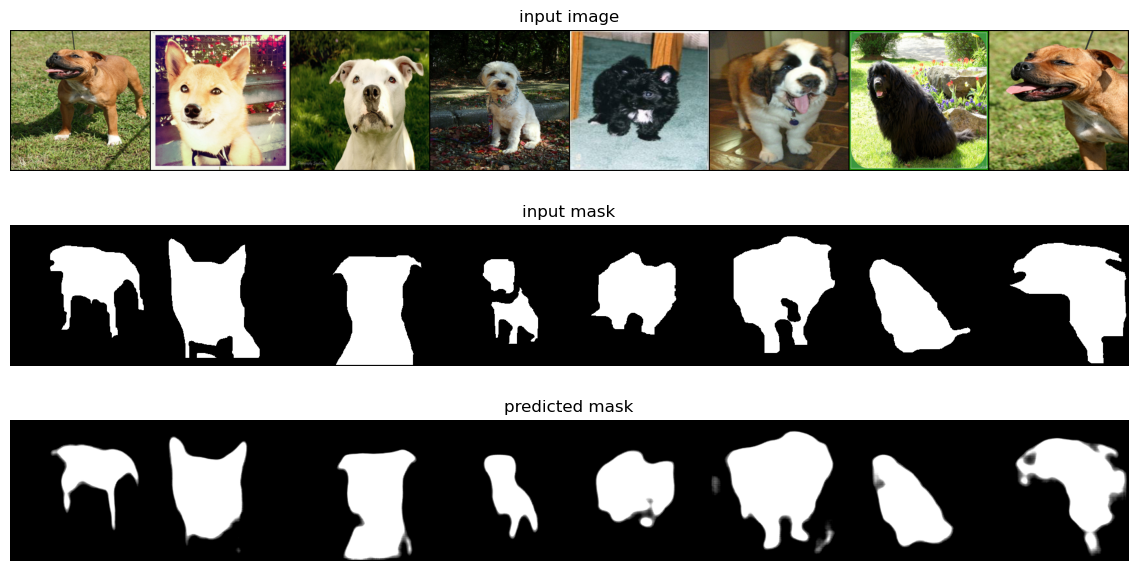

epochs - 9/15 [647/647], dice score: -1.2202785995473964, train loss: 0.2056743581383453, val loss: 0.20778140554325186


100%|██████████| 278/278 [00:04<00:00, 60.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


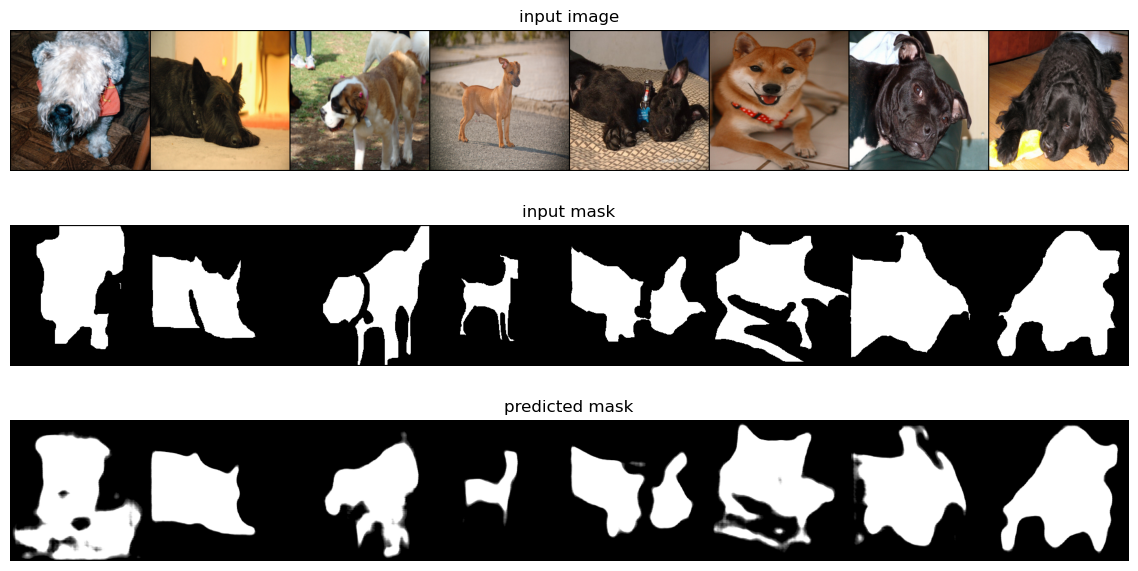

epochs - 10/15 [647/647], dice score: -3.007539473313222, train loss: 0.1945714345993546, val loss: 0.21157787992156668


100%|██████████| 278/278 [00:04<00:00, 60.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


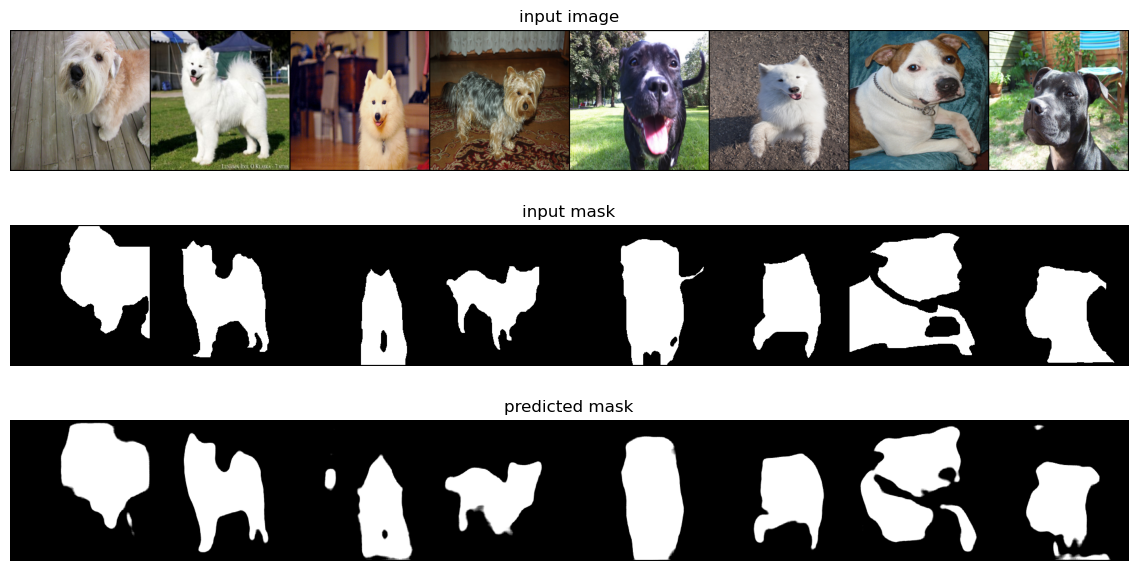

epochs - 11/15 [647/647], dice score: 4.653014816665392, train loss: 0.18070119927987066, val loss: 0.21226441136581434


100%|██████████| 278/278 [00:04<00:00, 60.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


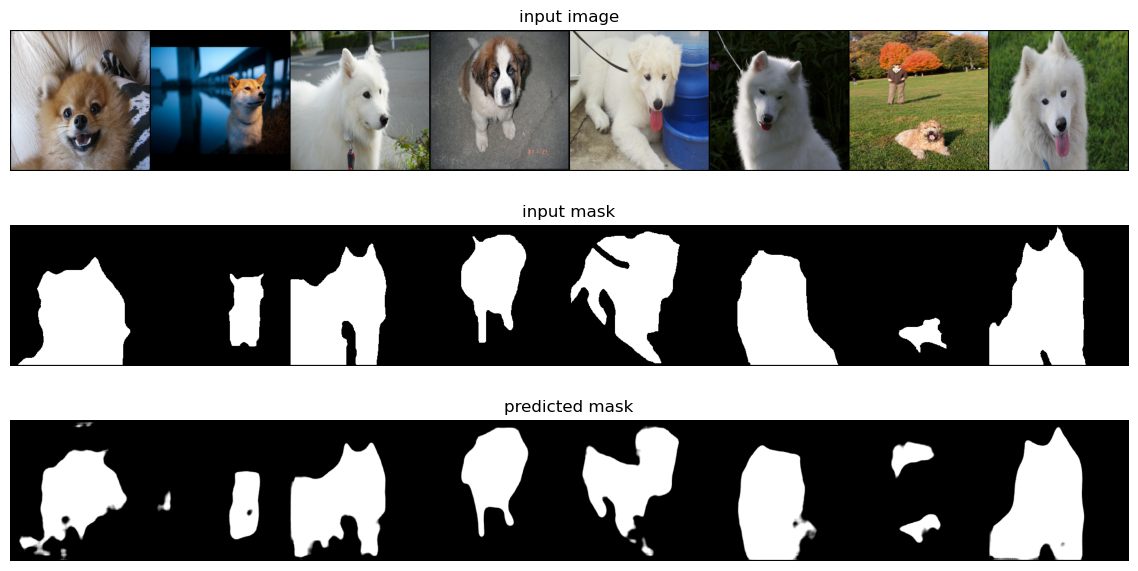

epochs - 12/15 [647/647], dice score: -1.2317673081009508, train loss: 0.1653150005332285, val loss: 0.20729787336836616


100%|██████████| 278/278 [00:04<00:00, 60.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


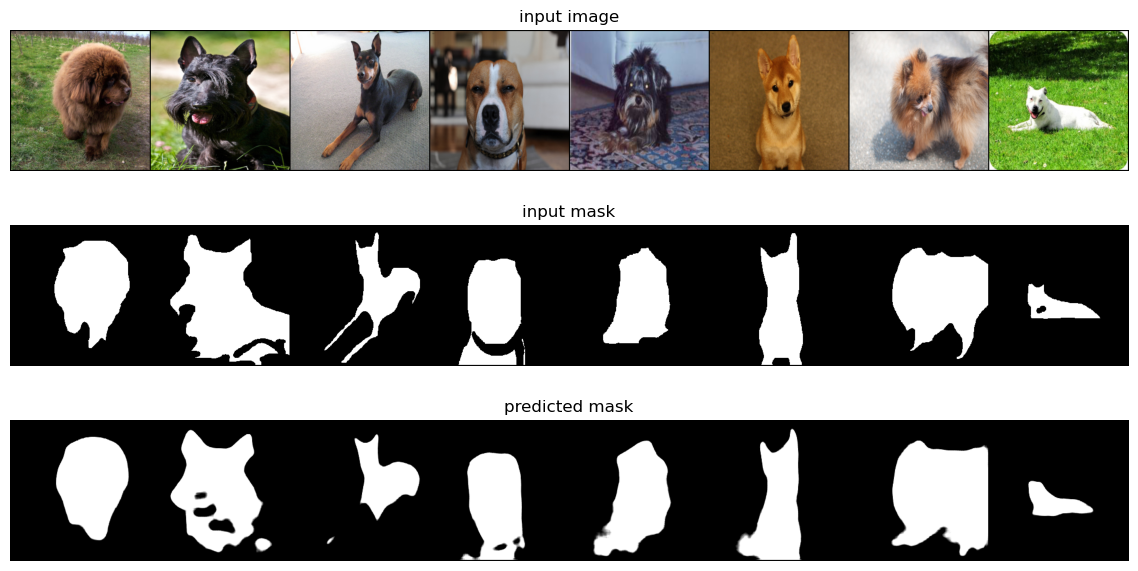

epochs - 13/15 [647/647], dice score: -1.1073886260068675, train loss: 0.15000450647964358, val loss: 0.19591513150137105


 29%|██▉       | 187/647 [00:08<00:18, 24.45it/s]

In [ ]:
model = UNet(in_channels=3, out_channels=1).to(device)

# The reason for using nn.BCEWithLogitsLoss() instead of using sigmoid activation followed by nn.BCELoss() separately is
# to avoid potential numerical instability.
# The separate approach could lead to numerical overflow or underflow when dealing with extreme values,
# which might cause training issues.
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, optimizer, criterion)

In [ ]:
def plot_history(history):
    plt.style.use('ggplot')
    plt.plot(history['valid_loss'], label='Validation')
    plt.plot(history['train_loss'], label='Training')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)